In [0]:
# Question 1
import numpy as np
import matplotlib.pyplot as plt
import math
from cvxopt import matrix, solvers

# Define Reward functions 1&2
rf1 = np.zeros((10, 10))
idx_n10 = ([2, 2, 3, 3, 4, 4, 5, 5, 8, 8, 9, 9], [5, 6, 5, 6, 1, 2, 1, 2, 2, 3, 2, 3])
rf1[idx_n10] = -10
rf1[9, 9] = 1

rf2 = np.zeros((10, 10))
rf2[1, 4:7] = -100
rf2[2, 4] = -100
rf2[2, 6] = -100
rf2[3:8, 4:9] = -100
rf2[3, 5] = 0
rf2[4:7, 5:8] = 0
rf2[7, 4:6] = 0
rf2[8, 6] = -100
rf2[9, 9] = 10

# Define actions
u, d, l, r = (-1, 0), (1, 0), (0, -1), (0, 1)
actions = [u, d, l, r]

In [0]:
# Plot heat maps
def plot_hm(m, size, title):
    """
    Input a matrix m and a title.
    Plot the heatmap for matrix m.
    """

    plt.pcolor(m)
    plt.axis([0, size, size, 0])
    plt.colorbar()
    plt.title(title)
    plt.show()


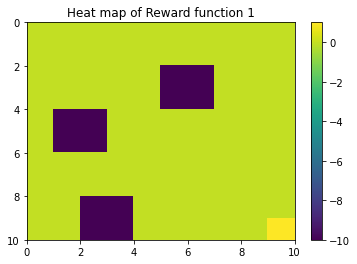

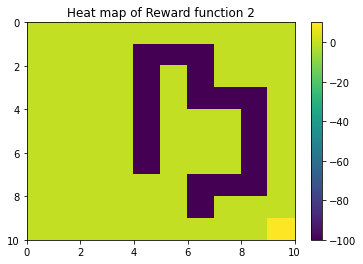

In [0]:
plot_hm(rf1, 10, "Heat map of Reward function 1")
plot_hm(rf2, 10, "Heat map of Reward function 2")

In [0]:
# Question 2

# Helper functions

def init_env(size, actions, w, gamma, rf):
    """
    Initialize an environment.
    Return the initial environment (size, actions, w, gamma, zero state-values and reward function).
    """
    sv = np.zeros((size, size))
    envi = {'size': size,
           'actions': actions,
           'w': w,
           'gamma': gamma,
           'sv': sv,
           'rf': rf}

    return envi

def transition(state, action, envi):
    """
    Take the size, current state, action, and environment as input.
    Return the possible resulting states with corresponding possibilities.
    """
    size = envi['size']
    actions = envi['actions']
    w = envi['w']

    r = np.array(state) + np.array(action)
    r = tuple(r)

    length = len(actions)
    prob = np.zeros(length+1)
    result = np.array([(0, 0) for idx in range(length+1)])

    for idx in range(length):
        s = np.array(state) + np.array(actions[idx])
        s = tuple(s)

        min_s = np.min(s)
        max_s = np.max(s)

        cur_p = 0
        if (s == r):
            cur_p = 1 - (length-1)*w/length
        else:
            cur_p = w/length

        if (min_s < 0 or max_s >= size):
            result[length] = state
            prob[length] += cur_p
        else:
            result[idx] = s
            prob[idx] += cur_p
    
    result = result[prob != 0]
    prob = prob[prob != 0]

    return (result, prob)

def try_action(state, action, envi):   
    """
    Given a current state, action, reward function and environment.
    Return the value of the input state-action.
    """
    rf = envi['rf']
    gamma = envi['gamma']
    sv = envi['sv']

    r, p = transition(state, action, envi)
    value = 0
    for idx in range(len(r)):
        x, y = r[idx]
        vr = rf[x, y] + gamma * sv[x, y]
        value += vr*p[idx]
    return value


def opt_v(envi, p=False):
    """
    Input an environment.
    Return a new environment with optimal state values.
    """
    size = envi['size']
    actions = envi['actions']

    new_env = dict(envi)
    opt_sv = new_env['sv']
    delta = math.inf
    n = 0
    eps = 0.01
    while (delta > eps):
        n += 1
        delta = 0
        for idx_x in range(size):
            for idx_y in range(size):
                v = opt_sv[idx_x, idx_y]
                av = list([])
                for a in actions:
                    av.append(try_action((idx_x, idx_y), a, new_env))
                max_v = np.max(av)
                opt_sv[idx_x, idx_y] = max_v
                delta = max(delta, abs(v-max_v))
        if (n%5==1):
            print_table(new_env, 'Step:'+str(n))

    if (p == True):
        print('It takes', n, 'iterations to achieve optimal values.')
    return new_env

def find_pi(envi):
    """
    Input environment.
    Return correponding policy.
    """
    size = envi['size']
    sv = envi['sv']
    actions = envi['actions']

    pi = [[(0, 0) for idx1 in range(size)] for idx2 in range(size)]
    for idx_x in range(size):
        for idx_y in range(size):
            v = sv[idx_x, idx_y]
            av = list([])
            for a in actions:
                av.append(try_action((idx_x, idx_y), a, envi))
            max_v = np.max(av)
            av = np.array(av)
            a = list()
            for idx_a in range(len(av)):
                if (av[idx_a] == max_v):
                    a.append(actions[idx_a])
            pi[idx_x][idx_y] = a
   
    return pi 

def print_table(envi, title):
    """
    Input environment and title.
    Print the state value table.
    """
    size = envi['size']
    sv = envi['sv']
    print(title)
    table_sv = list()
    for idx in range(size):
        table_sv.append(list(sv[idx]))

    for idx1 in range(size):
        for idx2 in range(size):
            table_sv[idx1][idx2] = float('%0.3f'%(table_sv[idx1][idx2]))

    table_labels = [str(idx) for idx in range(size)]
    table = plt.table(cellText=table_sv, rowLabels = table_labels, colLabels = table_labels, loc='center', edges='BR')
    table.set_fontsize(20)
    table.scale(2, 1.8)
    plt.axis('off')
    plt.show()

def print_pi(pi, title):
    """
    Input policy and title.
    Print the policy table.
    """
    pi_visual = [[0 for i in range(len(pi))] for j in range(len(pi[0]))]

    for i in range(len(pi)):
        for j in range(len(pi[i])):
            if (pi[i][j] == [(0, 1)]):
                pi_visual[i][j] = '→'
            elif (pi[i][j] == [(1, 0)]):
                pi_visual[i][j] = '↓'
            elif (pi[i][j] == [(0, -1)]):
                pi_visual[i][j] = '←'
            elif (pi[i][j] == [(-1, 0)]):
                pi_visual[i][j] = '↑'
            elif (pi[i][j] == [(-1, 0), (0,-1)]):
                pi_visual[i][j] = '←↑'
            elif (pi[i][j] == [(-1, 0), (0,1)]):
                pi_visual[i][j] = '↑→'
            elif (pi[i][j] == [(1, 0), (0,1)]):
                pi_visual[i][j] = '↓→'
            elif (pi[i][j] == [(1, 0), (0,-1)]):
                pi_visual[i][j] = '←↓'

    size = len(pi)
    print(title)
    table_pi = list()
    for idx in range(size):
        table_pi.append(list(pi_visual[idx]))


    table_labels = [str(idx) for idx in range(size)]
    table = plt.table(cellText=table_pi, rowLabels = table_labels, colLabels = table_labels, loc='center', edges='BR')
    table.set_fontsize(20)
    table.scale(2, 1.8)
    plt.axis('off')
    plt.show()


Step:1


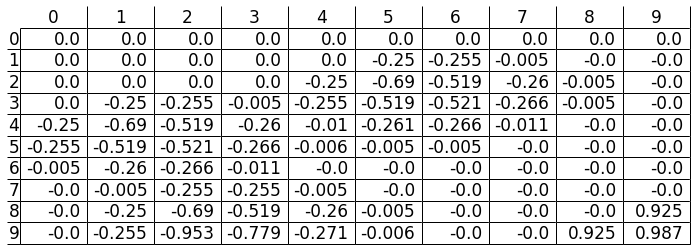

Step:6


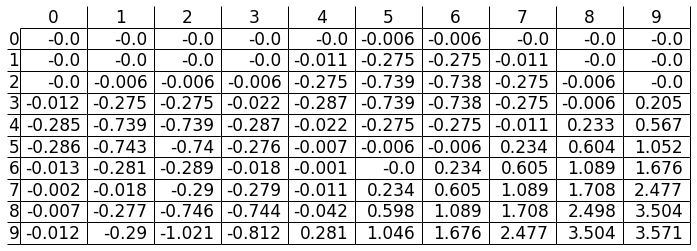

Step:11


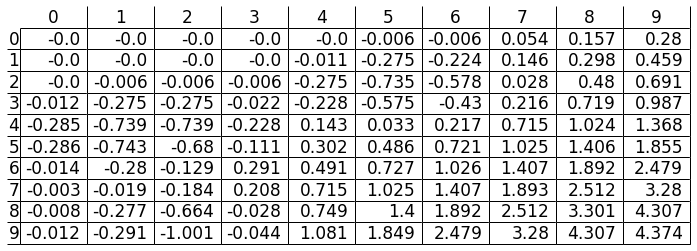

Step:16


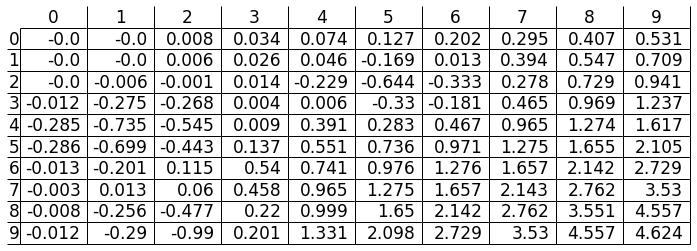

Step:21


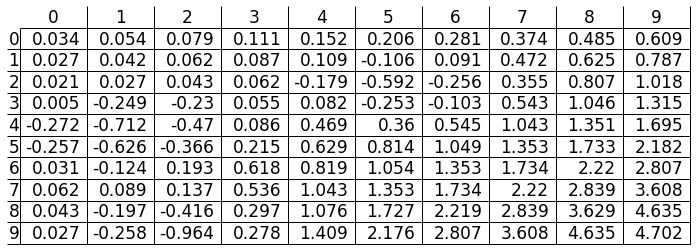

It takes 21 iterations to achieve optimal values.
Final state values


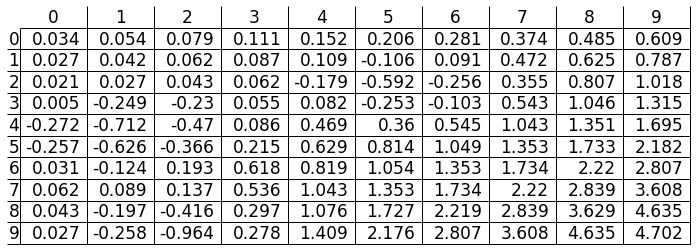

In [11]:
orig_env = init_env(10, actions, 0.1, 0.8, rf1)

new_env = opt_v(orig_env, True)
pi = find_pi(new_env)

print_table(new_env, 'Final state values')

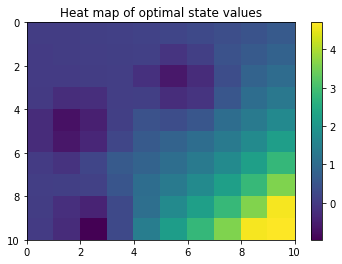

In [0]:
# Question 3
plot_hm(new_env['sv'], 10, "Heat map of optimal state values")

Optimal policy


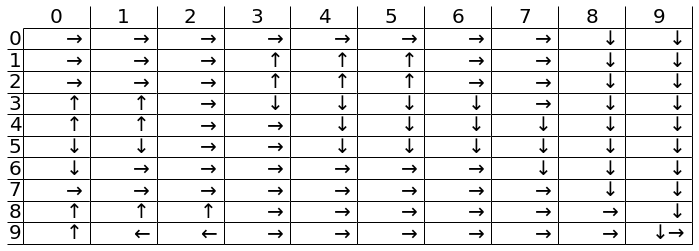

In [0]:
# Question 5
print_pi(pi, 'Optimal policy')

It takes 31 iterations to achieve optimal values.
Final state values


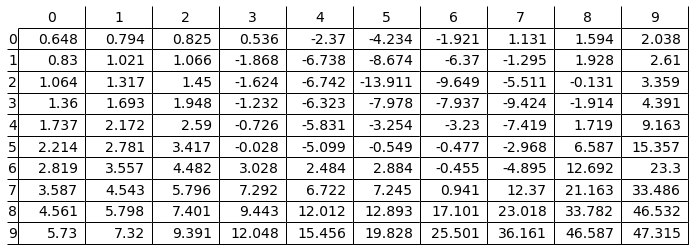

In [0]:
# Q6
orig_env_rw2 = init_env(10, actions, 0.1, 0.8, rf2)

new_env_rw2 = opt_v(orig_env_rw2, True)
pi_rw2 = find_pi(new_env_rw2)

print_table(new_env_rw2, 'Final state values')

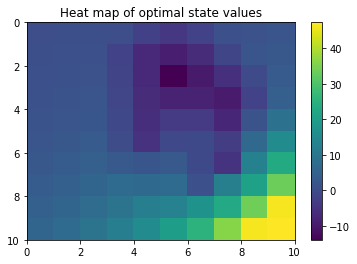

In [0]:
# Q7
plot_hm(new_env_rw2['sv'], 10, "Heat map of optimal state values")

Optimal policy


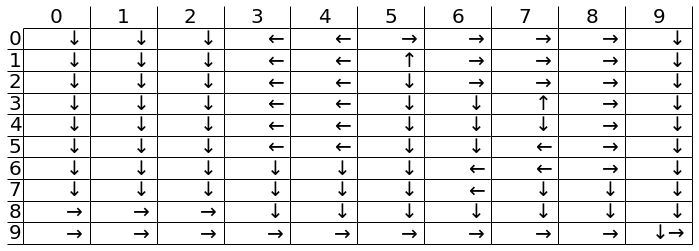

In [0]:
# Q8
print_pi(pi_rw2, 'Optimal policy')

It takes 16 iterations to achieve optimal values.
Final state values


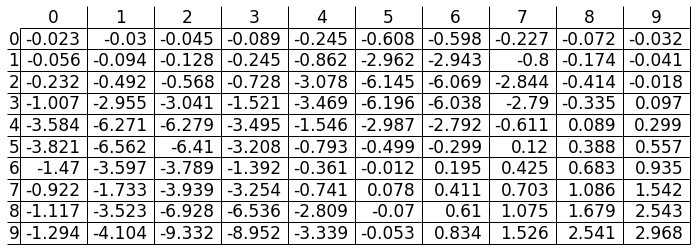

In [0]:
# Q9
# Reward function 1
# state values
orig_env_rw1_w2 = init_env(10, actions, 0.6, 0.8, rf1)

new_env_rw1_w2 = opt_v(orig_env_rw1_w2, True)
pi_rw1_w2 = find_pi(new_env_rw1_w2)

print_table(new_env_rw1_w2, 'Final state values')

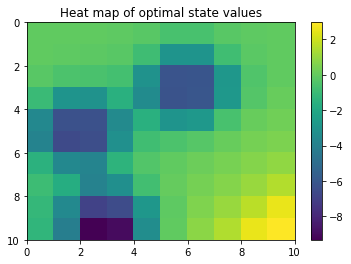

In [0]:
# Heat map of the optimal state values
plot_hm(new_env_rw1_w2['sv'], 10, "Heat map of optimal state values")

Optimal policy


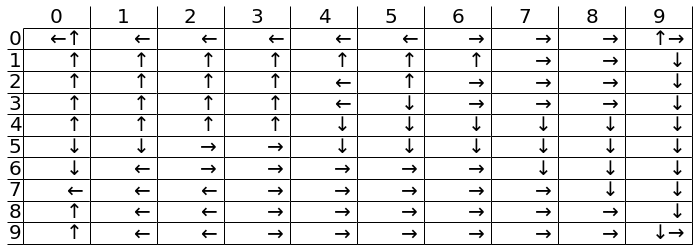

In [0]:
# Optimal policy
print_pi(pi_rw1_w2, 'Optimal policy')

It takes 22 iterations to achieve optimal values.
Final state values


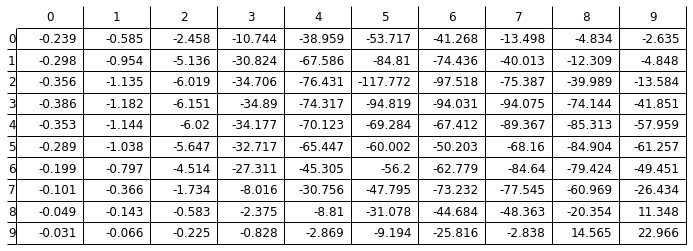

In [0]:
# Reward function 2
# state values
orig_env_rw2_w2 = init_env(10, actions, 0.6, 0.8, rf2)

new_env_rw2_w2 = opt_v(orig_env_rw2_w2, True)
pi_rw2_w2 = find_pi(new_env_rw2_w2)

print_table(new_env_rw2_w2, 'Final state values')

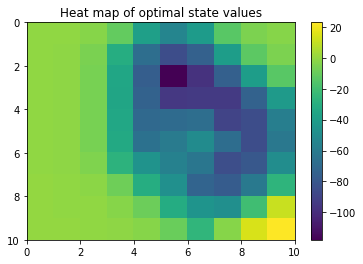

In [0]:
# Heat map of the optimal state values
plot_hm(new_env_rw2_w2['sv'], 10, "Heat map of optimal state values")

Optimal policy


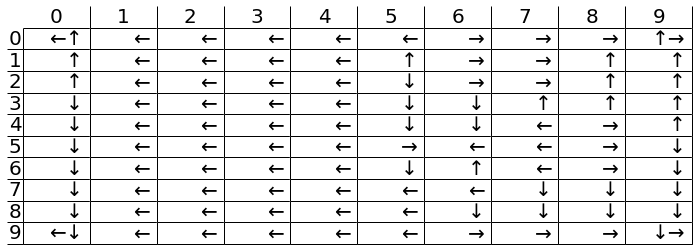

In [0]:
# Optimal policy
print_pi(pi_rw2_w2, 'Optimal policy')

In [0]:
# Helper functions
def find_var(envi, pi, lam):
    """
    Input an environment and a lambda.
    Return the b, c and D for the Linear Program corresponding to x.
    """
    size = envi['size']
    gamma = envi['gamma']
    max_r = max(abs(np.max(envi['rf'])), abs(np.min(envi['rf'])))
    num_states = size*size

    # Identity matrix of size num_states*num_states
    im1 = np.identity(num_states)
    
    # Compute c
    c = np.zeros((3*num_states, 1))
    c[num_states:2*num_states, :] = 1
    c[2*num_states:, :] = -lam

    # Compute first part of b
    b1 = np.ones((2*num_states, 1)) * max_r
    b1 = np.concatenate((b1, np.zeros((2*num_states, 1))), axis=0)

    # Compute first part of D
    zero1 = np.zeros(im1.shape)
    D11 = np.concatenate((im1, zero1, zero1), axis=1)
    D12 = np.concatenate((-im1, zero1, -im1), axis=1)
    D13 = np.concatenate((im1, zero1, -im1), axis=1)    
    D1 = np.concatenate((D11, -D11, D12, D13), axis=0)

    
    # Probability matrix of optimal policy pi.
    prob_opt = np.zeros((num_states, num_states))
    for i1 in range(size):
        for i2 in range(size):
            for a in pi[i1][i2]:
                r, p = transition((i1, i2), a, envi)
                for i3 in range(len(r)):
                    ns = r[i3]
                    prob_opt[i1*size+i2, ns[0]*size+ns[1]] += p[i3]
            
            prob_opt[i1*size+i2, :] /= len(pi[i1][i2])


    # Compute intermediate matrix A
    A = np.linalg.inv(im1 - gamma*prob_opt)

    # Compute second part of D
    # Compute intermediate matrix E
    E = list()
    im2 = list()
    for i1 in range(size):
        for i2 in range(size):
            nopt_a = list(set(actions) - set(pi[i1][i2]))
            for a in nopt_a:
                r, p = transition((i1, i2), a, envi)
                temp_prob = np.zeros((num_states))
                temp_im = np.zeros((num_states))
                temp_im[i1*size+i2] = 1
                for i3 in range(len(r)):
                    ns = r[i3]
                    temp_prob[ns[0]*size+ns[1]] += p[i3]
                temp_prob -= prob_opt[i1*size+i2]
                E.append(temp_prob)
                im2.append(temp_im)
    
    E = np.array(E)
    im2 = np.array(im2)
    G = np.matmul(E, A)

    zero2 = np.zeros(im2.shape)
    D21 = np.concatenate((G, im2, zero2), axis = 1)
    D22 = np.concatenate((G, zero2, zero2), axis = 1)
    D2 = np.concatenate((D21, D22), axis = 0)
    b2 = np.zeros((2*(zero2.shape[0]), 1))

    b = np.concatenate((b1, b2), axis=0)
    D = np.concatenate((D1, D2), axis=0)
         


    return (c, b, D)

def find_rf(c, b, D):
    c = matrix(c)
    b = matrix(b)
    D = matrix(D)
    solvers.options['show_progress'] = False
    sol = solvers.lp(-c, D, b)
    x = sol['x']
    x = np.array(x)
    R = x[:100, :]
    return R

def find_api(rf, envi, p=False):
    agent_env = init_env(envi['size'], envi['actions'], envi['w'], envi['gamma'], rf)
    agent_env = opt_v(agent_env, p)
    pi = find_pi(agent_env)
    return pi

def find_acc(api, epi):
    match = 0
    count = 0
    for i1 in range(len(api)):
        for i2 in range(len(api[0])):
            count += 1
            if (api[i1][i2] == epi[i1][i2]):
                match += 1

    return match/count

In [0]:
# Question 11

orig_env = init_env(10, actions, 0.1, 0.8, rf1)
new_env = opt_v(orig_env, True)
pi = find_pi(new_env)

lams = list(np.arange(0, 5, 0.01))
acc = list()
for l in lams: 
    c, b, D = find_var(orig_env, pi, l)
    agent_R = find_rf(c, b, D)
    agent_R = np.array(agent_R).reshape(-1, 10)
    agent_pi = find_api(agent_R, orig_env)
    acc.append(find_acc(agent_pi, pi))

It takes 21 iterations to achieve optimal values.


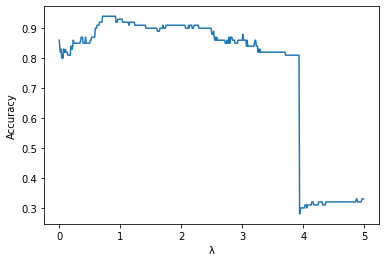

In [0]:
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.plot(lams, acc)
plt.show()

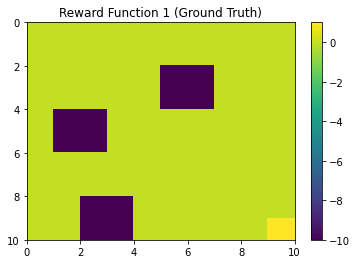

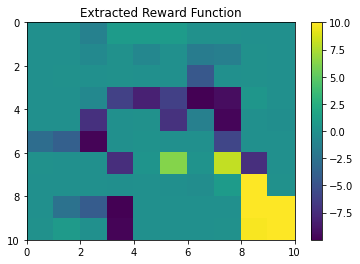

In [0]:
# Q13
max_lam = 0.82
c, b, D = find_var(orig_env, pi, max_lam)
agent_rf = find_rf(c, b, D)
agent_rf = np.array(agent_rf).reshape(-1, 10)
plot_hm(rf1, 10, 'Reward Function 1 (Ground Truth)')
plot_hm(agent_rf, 10, 'Extracted Reward Function')

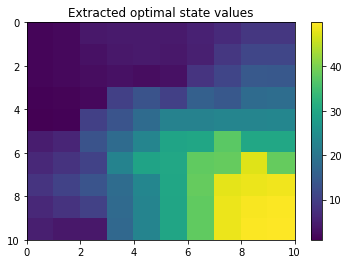

In [0]:
# Q14
agent_env = init_env(orig_env['size'], orig_env['actions'], orig_env['w'], orig_env['gamma'], agent_rf)
agent_env = opt_v(agent_env)
plot_hm(agent_env['sv'], 10, 'Extracted optimal state values')

Optimal policy


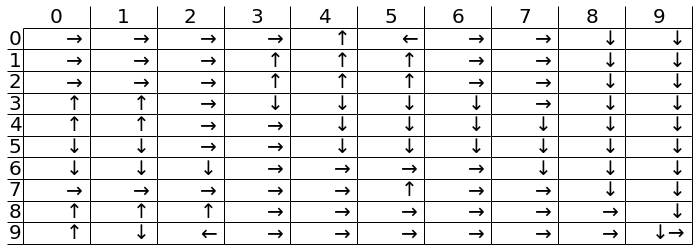

In [0]:
# Q16
agent_pi = find_pi(agent_env)
print_pi(agent_pi, 'Optimal policy')

In [0]:
# Question 18

orig_env_rw2 = init_env(10, actions, 0.1, 0.8, rf2)
new_env_rw2 = opt_v(orig_env_rw2, True)
pi_rw2 = find_pi(new_env_rw2)

lams = list(np.arange(0, 5, 0.01))
acc_rw2 = list()
for l in lams:
    c, b, D = find_var(orig_env_rw2, pi_rw2, l)
    agent_R = find_rf(c, b, D)
    agent_R = np.array(agent_R).reshape(-1, 10)
    agent_pi = find_api(agent_R, orig_env_rw2)
    acc_rw2.append(find_acc(agent_pi, pi_rw2))

In [0]:
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.plot(lams, acc_rw2)
plt.show()

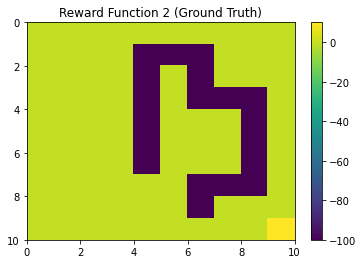

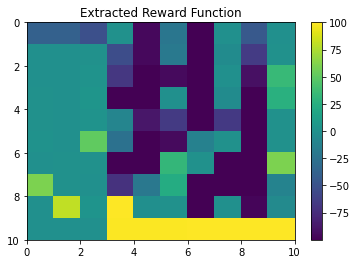

In [0]:
# Q20
max_lam = 0.52
c, b, D = find_var(orig_env_rw2, pi_rw2, max_lam)
agent_rf = find_rf(c, b, D)
agent_rf = np.array(agent_rf).reshape(-1, 10)
plot_hm(rf2, 10, 'Reward Function 2 (Ground Truth)')
plot_hm(agent_rf, 10, 'Extracted Reward Function')

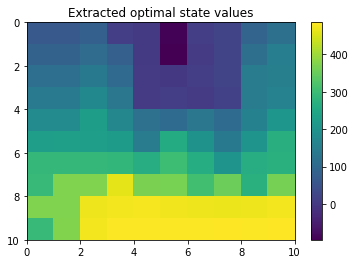

In [0]:
# Q21
agent_env = init_env(orig_env_rw2['size'], orig_env_rw2['actions'], orig_env_rw2['w'], orig_env_rw2['gamma'], agent_rf)
agent_env = opt_v(agent_env)
plot_hm(agent_env['sv'], 10, 'Extracted optimal state values')

Optimal policy


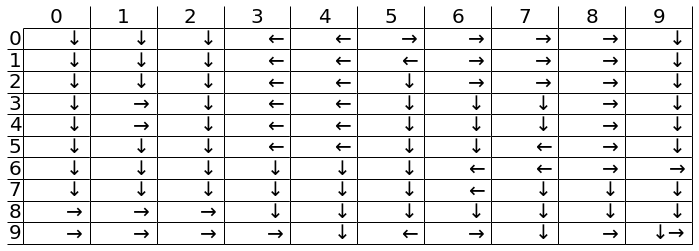

In [0]:
# Q23
agent_pi = find_pi(agent_env)
print_pi(agent_pi, 'Optimal policy')

In [0]:
# Q25
# New optimal value iteration
# Use smaller epsilon (10^(-9))
def new_opt_v(envi, p=False):
    """
    Input an environment.
    Return a new environment with optimal state values.
    """
    size = envi['size']
    actions = envi['actions']

    new_env = dict(envi)
    opt_sv = new_env['sv']
    delta = math.inf
    n = 0
    eps = 1e-9
    while (delta > eps):
        n += 1
        delta = 0
        for idx_x in range(size):
            for idx_y in range(size):
                v = opt_sv[idx_x, idx_y]
                av = list([])
                for a in actions:
                    av.append(try_action((idx_x, idx_y), a, new_env))
                max_v = np.max(av)
                opt_sv[idx_x, idx_y] = max_v
                delta = max(delta, abs(v-max_v))
    
    if (p == True):
        print('It takes', n, 'iterations to achieve optimal values.')
    return new_env

# New optimal policy
def new_find_api(rf, envi, p=False):
    agent_env = init_env(envi['size'], envi['actions'], envi['w'], envi['gamma'], rf)
    agent_env = new_opt_v(agent_env, p)
    pi = find_pi(agent_env)
    return pi

In [0]:
# New IRL Linear Program
# Limit new Ri's within the true R_max and R_min (instead of maximum absolute value)
def new_find_var(envi, pi, lam):
    """
    Input an environment and a lambda.
    Return the b, c and D for the Linear Program corresponding to x.
    """
    size = envi['size']
    gamma = envi['gamma']
    max_r = np.max(envi['rf'])
    min_r = -np.min(envi['rf'])
    num_states = size*size

    # Identity matrix of size num_states*num_states
    im1 = np.identity(num_states)
    
    # Compute c
    c = np.zeros((3*num_states, 1))
    c[num_states:2*num_states, :] = 1
    c[2*num_states:, :] = -lam

    # Compute first part of b
    b11 = np.ones((num_states, 1)) * max_r
    b12 = np.ones((num_states, 1)) * min_r
    b1 = np.concatenate((b11, b12), axis=0)
    b1 = np.concatenate((b1, np.zeros((2*num_states, 1))), axis=0)

    # Compute first part of D
    zero1 = np.zeros(im1.shape)
    D11 = np.concatenate((im1, zero1, zero1), axis=1)
    D12 = np.concatenate((-im1, zero1, -im1), axis=1)
    D13 = np.concatenate((im1, zero1, -im1), axis=1)    
    D1 = np.concatenate((D11, -D11, D12, D13), axis=0)

    
    # Probability matrix of optimal policy pi.
    prob_opt = np.zeros((num_states, num_states))
    for i1 in range(size):
        for i2 in range(size):
            for a in pi[i1][i2]:
                r, p = transition((i1, i2), a, envi)
                for i3 in range(len(r)):
                    ns = r[i3]
                    prob_opt[i1*size+i2, ns[0]*size+ns[1]] += p[i3]
            
            prob_opt[i1*size+i2, :] /= len(pi[i1][i2])


    # Compute intermediate matrix A
    A = np.linalg.inv(im1 - gamma*prob_opt)

    # Compute second part of D
    # Compute intermediate matrix E
    E = list()
    im2 = list()
    for i1 in range(size):
        for i2 in range(size):
            nopt_a = list(set(actions) - set(pi[i1][i2]))
            for a in nopt_a:
                r, p = transition((i1, i2), a, envi)
                temp_prob = np.zeros((num_states))
                temp_im = np.zeros((num_states))
                temp_im[i1*size+i2] = 1
                for i3 in range(len(r)):
                    ns = r[i3]
                    temp_prob[ns[0]*size+ns[1]] += p[i3]
                temp_prob -= prob_opt[i1*size+i2]
                E.append(temp_prob)
                im2.append(temp_im)
    
    E = np.array(E)
    im2 = np.array(im2)
    G = np.matmul(E, A)

    zero2 = np.zeros(im2.shape)
    D21 = np.concatenate((G, im2, zero2), axis = 1)
    D22 = np.concatenate((G, zero2, zero2), axis = 1)
    D2 = np.concatenate((D21, D22), axis = 0)
    b2 = np.zeros((2*(zero2.shape[0]), 1))

    b = np.concatenate((b1, b2), axis=0)
    D = np.concatenate((D1, D2), axis=0)
         


    return (c, b, D)

It takes 100 iterations to achieve optimal values.
Optimal policy


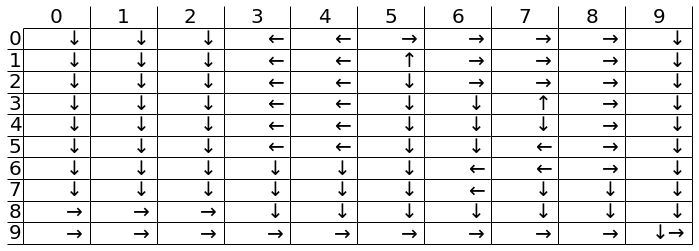

In [19]:
# Q25
# Use new value iteration on reward function 2
max_lam = 0.52

orig_env_rw2 = init_env(10, actions, 0.1, 0.8, rf2)
new_env_rw2 = new_opt_v(orig_env_rw2, True)
pi_rw2 = find_pi(new_env_rw2)

c, b, D = find_var(orig_env_rw2, pi_rw2, max_lam)
agent_rf = find_rf(c, b, D)
agent_rf = np.array(agent_rf).reshape(-1, 10)

agent_env = init_env(orig_env_rw2['size'], orig_env_rw2['actions'], orig_env_rw2['w'], orig_env_rw2['gamma'], agent_rf)
agent_env = new_opt_v(agent_env)

agent_pi = find_pi(agent_env)
print_pi(agent_pi, 'Optimal policy')

In [20]:
print(find_acc(agent_pi, pi_rw2))

1.0


In [0]:
lams = list(np.arange(0, 5, 0.01))
acc = list()
for l in lams:    
    c, b, D = find_var(orig_env_rw2, pi_rw2, l)
    agent_R = find_rf(c, b, D)
    agent_R = np.array(agent_R).reshape(-1, 10)
    agent_pi = new_find_api(agent_R, orig_env_rw2)
    acc.append(find_acc(agent_pi, pi_rw2))

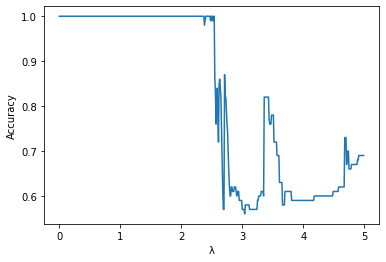

In [0]:
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.plot(lams, acc)
plt.show()